In [87]:
# %load main.py
"""
@Time    :2019/12/10 18:04
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json

from fastai.vision import ImageList, Image, CategoryList
from pandas import DataFrame
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
import logging
import torch
from fastai.vision import *
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


class MyImageList(ImageList):
    @classmethod
    def from_df(cls, df:DataFrame, path, cols=0, folder=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        values = df.iloc[:, 1: ].values
        labels = df.iloc[:, 0].values
        values = torch.tensor(values).float()
        items = []
        for y, v in zip(labels, values):
            t = Image(v.view(28, 28).unsqueeze(0))
            t.y = y
            items.append(t)
        # res = cls(items, label_cls=CategoryList)
        res = cls(items)
        return res
    
    @classmethod
    def from_test_data(cls, pth):
        # 从测试集合上读取
        df = pd.read_csv(pth)
        values = df.values
        indexs = df.index
        values = torch.tensor(values).float()
        items = []
        for i, v in zip(indexs, values):
            t = Image(v.view(28, 28).unsqueeze(0))
            t.index = i
            items.append(t)
      
        # res = cls(items, label_cls=CategoryList)
        res = cls(items)
        return res
    
    def get(self, i):
        res = self.items[i]
        return res

In [88]:
pth = r'/home/liangjiaxi/TMP_PROJECT/fastaipractice/data/数字图像识别'
data = MyImageList.from_csv(pth, 'train.csv', cols= list(range(1, 785)))
data = data.split_by_rand_pct(0.2, 0)
data = data.label_from_func(lambda x: x.y)

In [89]:
# tfms = tfms = get_transforms(do_flip=False)
# tfms = [rotate(degrees=(-20,20)), symmetric_warp(magnitude=(-0.3,0.3))]
# data = data.transform(tfms)


In [90]:
data = data.databunch(device = 'cuda', bs = 64)

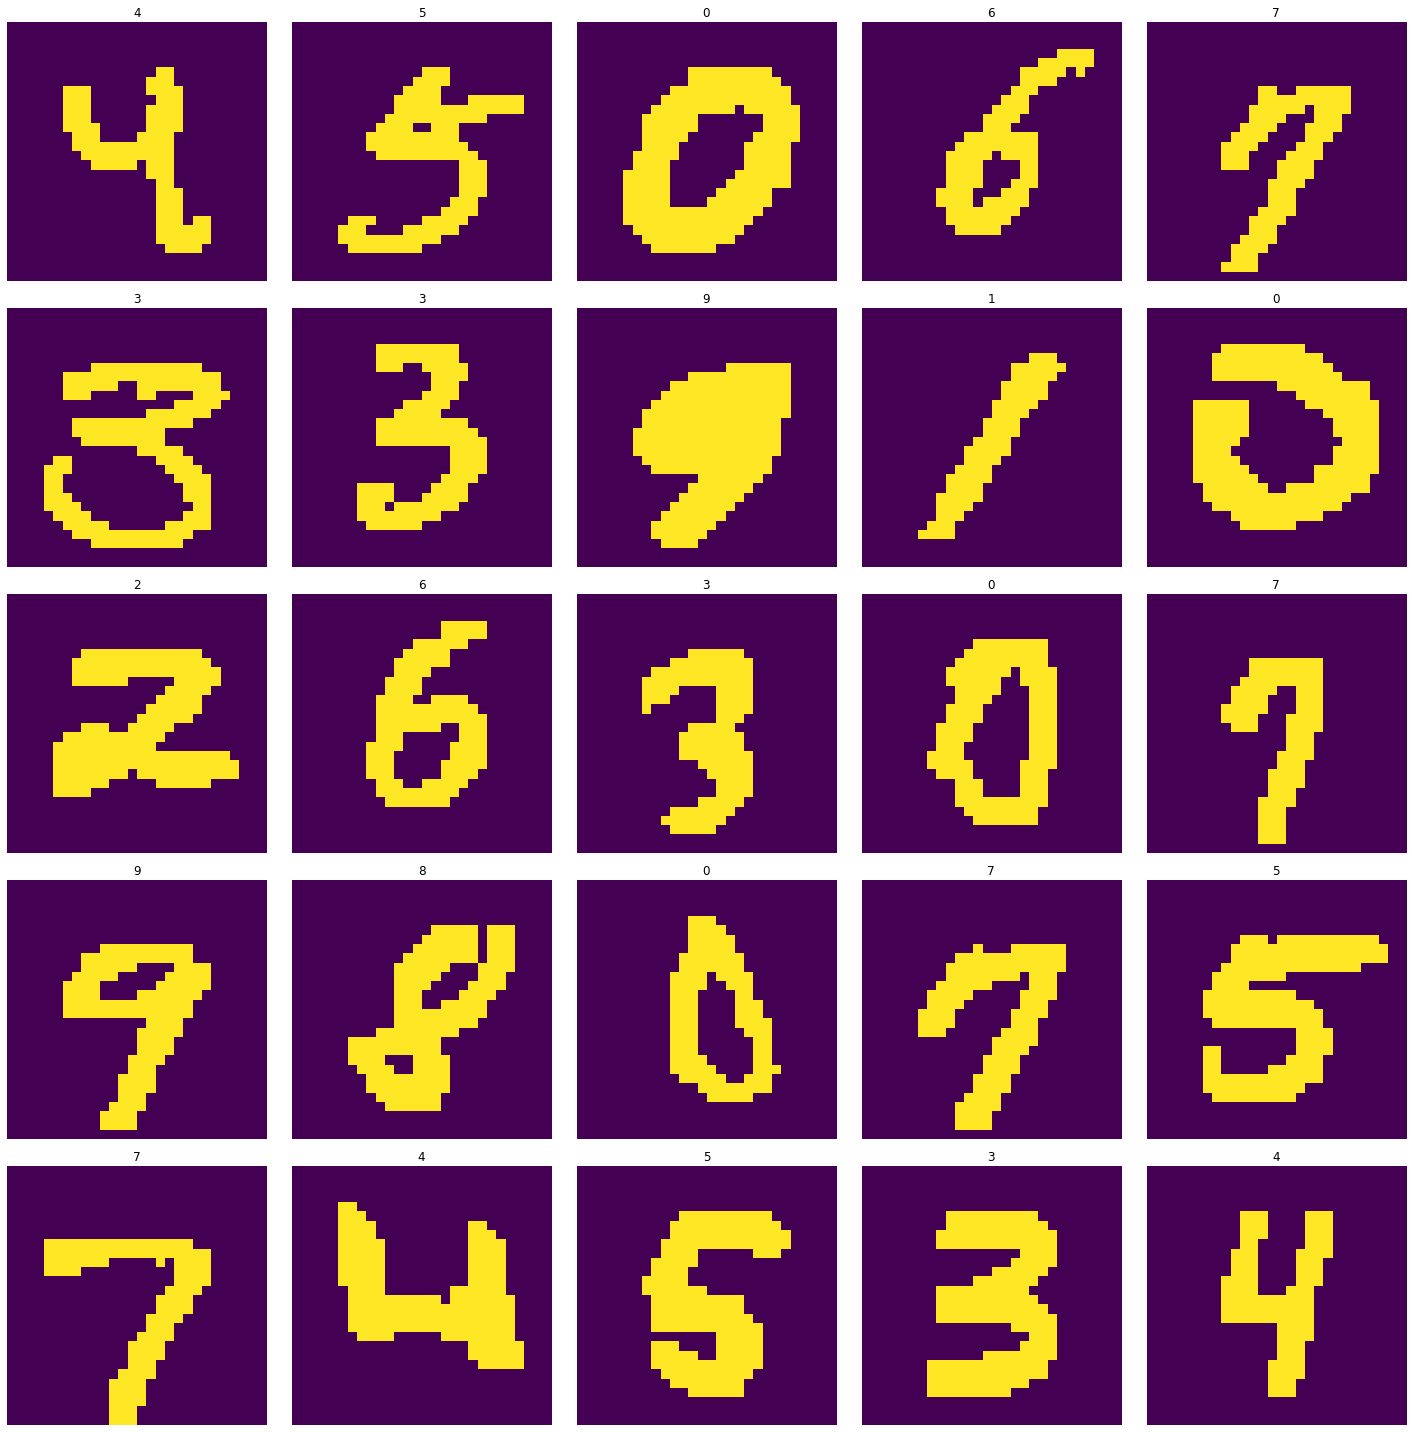

In [91]:
data.show_batch()

In [92]:
data.train_ds[5][0]

In [93]:
"""
@Time    :2019/12/10 18:04
@Author  : 梁家熙
@Email:  :11849322@mail.sustech.edu.cn
"""
import json
from fastai import *
from fastai.vision import *
from fastai.vision import ImageList, Image, CategoryList
from pandas import DataFrame
from tqdm import tqdm
import random
from pprint import pprint
import os
import collections
from typing import List, Dict, Tuple
from fastai.vision.gan import basic_critic, AvgFlatten
import logging
import torch
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

class MyCNN(torch.nn.Module):
    def __init__(self, in_size:int, n_channels:int, n_features:int=64, n_extra_layers:int=0, **conv_kwargs):
        super(MyCNN, self).__init__()
        "A basic critic for images `n_channels` x `in_size` x `in_size`."
        layers = [
            conv_layer(n_channels, n_features, 3, 2, 1, leaky=0.2, norm_type=None, **conv_kwargs)]  # norm_type=None?
        cur_size, cur_ftrs = in_size // 2, n_features
        layers.append(nn.Sequential(
            *[conv_layer(cur_ftrs, cur_ftrs, 3, 1, leaky=0.2, **conv_kwargs) for _ in range(n_extra_layers)]))
        while cur_size > 4:
            layers.append(conv_layer(cur_ftrs, cur_ftrs * 2, 4, 2, 1, leaky=0.2, **conv_kwargs))
            cur_ftrs *= 2
            cur_size //= 2
        # layers += [conv2d(cur_ftrs, 1, 3, padding=0)]

        layers += [ResizeBatch( -1), torch.nn.Linear(256*3*3, 10) ]
        self.layers = torch.nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(-1, 10)
        return x

model = MyCNN(28, 1)
learn = Learner(data, model, metrics = accuracy)

In [94]:
learn.lr_find(num_it=1000)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


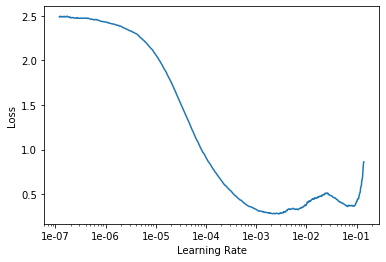

In [95]:
learn.recorder.plot()

In [96]:
learn.summary()

MyCNN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 14, 14]         640        True      
______________________________________________________________________
LeakyReLU            [64, 14, 14]         0          False     
______________________________________________________________________
Sequential           [64, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [128, 7, 7]          131,072    True      
______________________________________________________________________
LeakyReLU            [128, 7, 7]          0          False     
______________________________________________________________________
BatchNorm2d          [128, 7, 7]          256        True      
______________________________________________________________________
Conv2d               [256, 3, 3]          524,288    True      
________________________________________________________

In [97]:
learn.fit_one_cycle(5, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.316720,0.262568,0.932143,00:28
1,0.114647,0.118225,0.967262,00:26
2,0.067385,0.082067,0.976548,00:29
3,0.042915,0.067744,0.979762,00:28
4,0.034388,0.065590,0.980833,00:28


In [98]:
learn.save('0.9888')

In [99]:
learn.load('0.9888')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: MyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: .;

Valid: LabelList (8400 items)
x: MyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
3,6,9,5,6
Path: .;

Test: None, model=MyCNN(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential()
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(n

In [100]:
interp = ClassificationInterpretation.from_learner(learn)

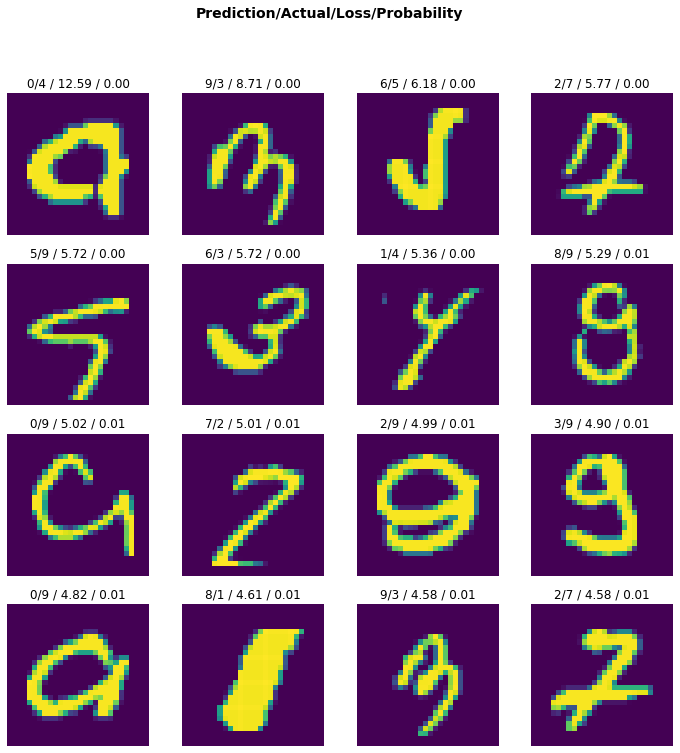

In [101]:
interp.plot_top_losses(16)

In [102]:
datalist = MyImageList.from_test_data('/home/liangjiaxi/TMP_PROJECT/fastaipractice/data/数字图像识别/test.csv')\
    .split_none()\
    .label_from_func(lambda x: x.index)\
    .databunch()

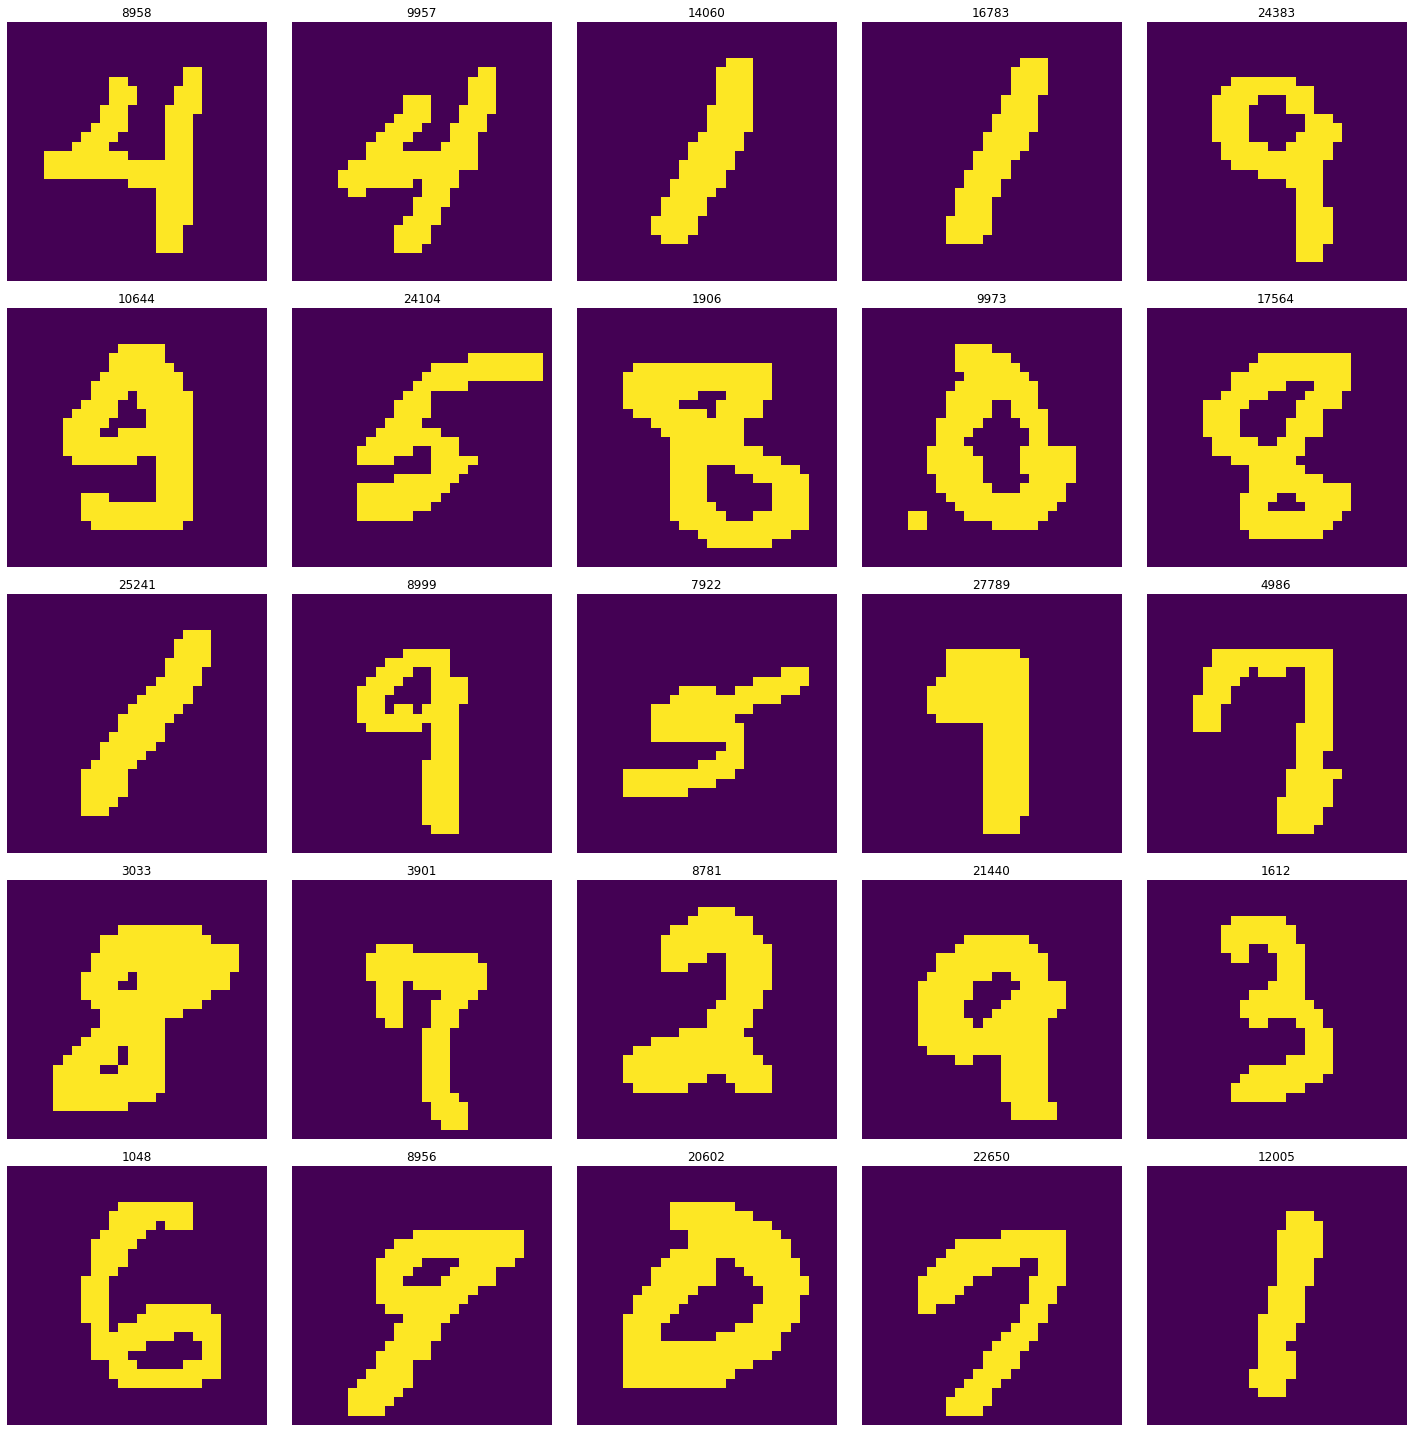

In [103]:
datalist.show_batch()

In [104]:
learn.predict(datalist.train_ds.item)

(Category 3,
 tensor(3),
 tensor([1.6279e-04, 4.5975e-05, 4.5929e-04, 9.6036e-01, 1.5815e-04, 1.8018e-02,
         1.0370e-05, 9.3178e-05, 1.9665e-02, 1.0283e-03]))

In [105]:
indexs = []
ans = []
for x, index in tqdm(datalist.train_ds):
    p = (learn.predict(x)[1].item())
    indexs.append(index)
    ans.append(p)

100%|██████████| 28000/28000 [02:21<00:00, 197.66it/s]


In [106]:
result = pd.DataFrame({'ImageId': indexs, 'Label': ans})

In [107]:
result.head()

,ImageId,Label
0,0,2
1,1,0
2,2,9
3,3,9
4,4,3


In [108]:
result.to_csv('./result.csv', index = None)